In [1]:
#default_exp basics.interp

# Showing prediction results for specific items (Beginner)

> Extending the `Interpretation` class with the `show_at` method

In [7]:
#hide
from nbdev.showdoc import *
from wwf.utils import *

In [2]:
#hide_input
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.2.5 
* `fastcore`: 1.3.19 
* `wwf`: 0.0.9 
---

## My problem

I often want to look at the predictions of specific items in the validation set, to see if I can find patterns in the errors made by the model. This notebook extends the `Interpretation` object created on top of a learner to add a shortcut method, `show_at` that does exactly this.  Let's use as example the "is a cat" classifier, as trained in the [fastbook](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb) 

In [3]:
# export
from fastai.basics import *

/mnt/d/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Creating a `ClassificationInterpretation` from the learner will give us shorcuts to interpret its results. By default, the Intepretation object will be created around the validation dataloader

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Let's say we are interested in the predictions for the first item of the validation set. Normally, what I do to visualize both the item and predictions for a single item is to first show it in the dataset and then see its prediction in `interp.preds` or `interp.decoded`

In [ ]:
item_idx = 0
show_at(dls.valid.dataset, item_idx)
print(interp.decoded[item_idx])

It would be much easier if we could just call `show_at` as a method of the `interp` object, and plot the results in the same way that `learn.show_results` does it. Here's a piece of code by Zach Mueller, taken from the discord community, to achieve this goal.

In [4]:
#exports
@patch
def __getitem__(self:Interpretation, idxs):
    "Get the inputs, preds, targets, decoded outputs, and losses at `idxs`"
    if not is_listy(idxs): idxs = [idxs]
    attrs = 'inputs,preds,targs,decoded,losses'
    res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
    return res

In [5]:
#exports
@patch
@delegates(TfmdDL.show_results)
def show_at(self:Interpretation, idxs, **kwargs):
    "Show predictions on the items at `idxs`"
    inp, _, targ, dec, _ = self[idxs]
    self.dl.show_results((inp, dec), targ, **kwargs)

As you can see, the code of the `show_at` method is pretty simple. It uses the fastcore's 
`@patch` decorator to add the method to the class `Interpretation` (therefore the `self:Interpretation` as first argument), and the `@delegates` decorator to replace
`**kwargs` in the signature of the method with the arguments of `show_results`. All the function does is grab the inputs, targets and decoded predictions from the corresponding attributes of the Interpretation object, and call `show_results` from its dataloader. By default, when the `Interpretation` object is created using the method `from_learner`, this dataloader is the validation dataloader used in the training.

Grabbing the inputs, targets and decoded predictions is done by calling `self[idxs]`. For that to work, we need a `__getitem__` method in the class `Interpretation`. That method calls `getattr` for every indexable attribute within
Interpretation (i.e, inputs, predictions, decoded predictions, targets, and losses).

Let's see now an example of how `show_at` work for a single item, in this case, the first element of the validation dataset.

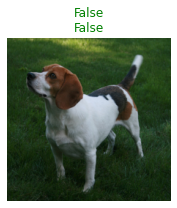

In [ ]:
interp.show_at(0)

Here's another example to show the predictions of multiple items, namely the three
elements of the validation set with the largest loss

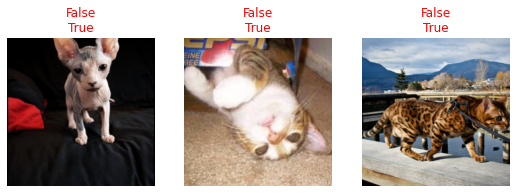

In [ ]:
interp.show_at(interp.top_losses(3).indices)

Additionaly, the method `__getitem__` is also very useful when you want to know everything (data, prediction, decoded prediction, actual label) of a specific item of the dataset.

In [ ]:
interp[:3]

(#5) [TensorImage([[[[-1.0733, -1.1589, -1.2274,  ..., -1.5185, -1.4500, -1.4500],
          [-1.2103, -1.1247, -1.1932,  ..., -1.5014, -1.4500, -1.5014],
          [-1.2788, -1.1589, -1.2103,  ..., -1.5185, -1.4843, -1.5357],
          ...,
          [-1.8953, -1.7925, -1.8268,  ..., -1.6727, -1.7583, -1.8439],
          [-1.9295, -1.7754, -1.8268,  ..., -1.6555, -1.7412, -1.8610],
          [-1.8268, -1.7925, -1.8782,  ..., -1.7925, -1.7412, -1.6898]],

         [[-0.4951, -0.5651, -0.6702,  ..., -0.8627, -0.7927, -0.8277],
          [-0.5651, -0.4776, -0.6176,  ..., -0.7927, -0.7577, -0.7927],
          [-0.6176, -0.5126, -0.6352,  ..., -0.8277, -0.7927, -0.8627],
          ...,
          [-1.4930, -1.3179, -1.3529,  ..., -1.2479, -1.3880, -1.4580],
          [-1.5105, -1.2654, -1.3529,  ..., -1.2129, -1.3354, -1.4580],
          [-1.4405, -1.2829, -1.4405,  ..., -1.3354, -1.3354, -1.3179]],

         [[-1.0724, -1.1596, -1.2119,  ..., -1.2816, -1.2467, -1.2467],
          [-1.1944,